In [1]:
#Import all the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys 
import os
import tensorflow as tf
import pickle
import sklearn
import itertools
%matplotlib inline

from sklearn.model_selection import train_test_split 
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import models, layers
from keras.layers import RepeatVector, Input, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, MaxPool2D
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.models import Sequential
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Reshape
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix 
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings("ignore")

In [2]:
data_path = "SKINDISEASE DATASET"
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
NUM_EPOCHS = 5
NUM_CLASSES = 4


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42)

val_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=42)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    data_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False)


Found 1120 images belonging to 4 classes.
Found 280 images belonging to 4 classes.
Found 1400 images belonging to 4 classes.


In [4]:
model_input = Input(shape=(256, 256, 3))

In [5]:
input_shape = (256, 256, 3) # Change to (512,512,3)
input_tensor = model_input

# create the VGG model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# freeze the first few layers
for layer in vgg_model.layers[:10]:
   layer.trainable = False

# create the Xception model
xception_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# freeze the first few layers
for layer in xception_model.layers[:10]:
   layer.trainable = False

# concatenate the output tensors
vgg_output = vgg_model(input_tensor)
xception_output = xception_model(input_tensor)
concatenated = tf.keras.layers.Concatenate(axis=-1)([vgg_output, xception_output])

# add some more layers
x = tf.keras.layers.GlobalMaxPooling2D()(concatenated)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
classification_layer = tf.keras.layers.Dense(4, activation='sigmoid')(x)

# create the final model
ensemble_model = tf.keras.models.Model(inputs=input_tensor, outputs=classification_layer)

# compile the model
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


In [6]:
history = ensemble_model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    validation_data=val_generator,
    verbose=1,
    epochs=NUM_EPOCHS,
)


Epoch 1/5
35/35 [==============================] - 1236s 35s/step - loss: 0.5113 - accuracy: 0.5366 - val_loss: 0.3468 - val_accuracy: 0.6679
Epoch 2/5
35/35 [==============================] - 1213s 35s/step - loss: 0.2520 - accuracy: 0.8080 - val_loss: 0.3083 - val_accuracy: 0.7393
Epoch 3/5
35/35 [==============================] - 1222s 35s/step - loss: 0.1625 - accuracy: 0.8875 - val_loss: 0.2890 - val_accuracy: 0.7821
Epoch 4/5
35/35 [==============================] - 1375s 39s/step - loss: 0.0975 - accuracy: 0.9393 - val_loss: 0.3267 - val_accuracy: 0.7821
Epoch 5/5
35/35 [==============================] - 1160s 33s/step - loss: 0.0629 - accuracy: 0.9616 - val_loss: 0.3262 - val_accuracy: 0.7786


In [7]:
loss_val, acc_val = ensemble_model.evaluate(test_generator, verbose=1)
print("Test: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))


44/44 [==============================] - 567s 13s/step - loss: 0.0973 - accuracy: 0.9371
Test: accuracy = 0.937143  ;  loss_v = 0.097319


In [8]:
loss_val, acc_val = ensemble_model.evaluate(val_generator, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))


9/9 [==============================] - 117s 13s/step - loss: 0.2793 - accuracy: 0.8179
Validation: accuracy = 0.817857  ;  loss_v = 0.279264


In [21]:
yTrue = test_generator.classes

44/44 [==============================] - 583s 13s/step


[]

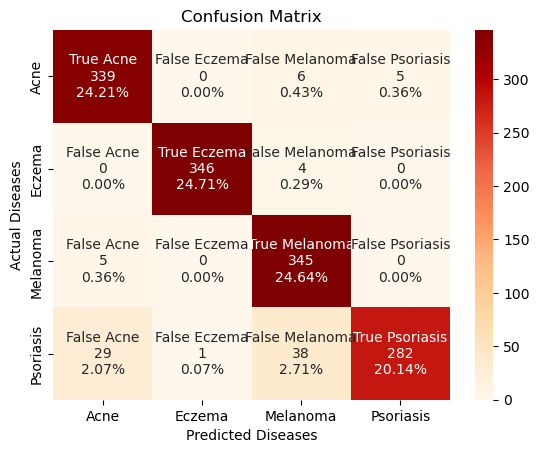

In [22]:
classes_ = ['Acne', 'Eczema', 'Melanoma', 'Psoriasis']

# Generate the confusion matrix for the model
y_pred = np.argmax(ensemble_model.predict(test_generator), axis=-1)
conf_mat = confusion_matrix(yTrue, y_pred, labels=range(len(classes_)))

group_names = ['True Acne','False Eczema','False Melanoma','False Psoriasis',
               'False Acne','True Eczema','False Melanoma','False Psoriasis',
               'False Acne','False Eczema','True Melanoma','False Psoriasis',
               'False Acne','False Eczema','False Melanoma','True Psoriasis']

group_counts = ["{0:0.0f}".format(value) for value in
                conf_mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(len(classes_),len(classes_))

ax = sns.heatmap(conf_mat, annot=labels, yticklabels=classes_, xticklabels=classes_, fmt='', cmap='OrRd')
ax.set(title='Confusion Matrix', xlabel='Predicted Diseases', ylabel='Actual Diseases')
ax.plot()

In [23]:
report = classification_report(yTrue, y_pred, target_names=classes_)
print(report)

              precision    recall  f1-score   support

        Acne       0.91      0.97      0.94       350
      Eczema       1.00      0.99      0.99       350
    Melanoma       0.88      0.99      0.93       350
   Psoriasis       0.98      0.81      0.89       350

    accuracy                           0.94      1400
   macro avg       0.94      0.94      0.94      1400
weighted avg       0.94      0.94      0.94      1400



In [24]:
accuracy = history.history['accuracy']
validationAccuracy = history.history['val_accuracy']

loss = history.history['loss']
validationLoss = history.history['val_loss']

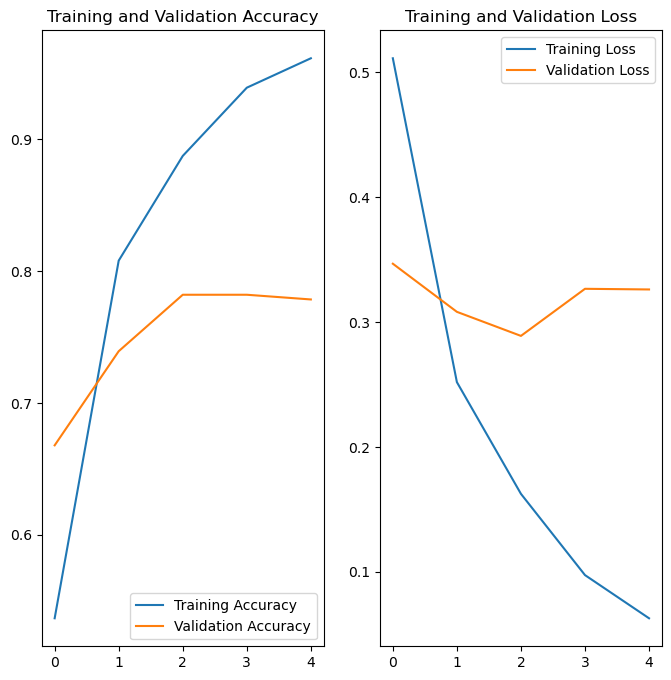

In [25]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(NUM_EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(NUM_EPOCHS), validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(NUM_EPOCHS), loss, label='Training Loss')
plt.plot(range(NUM_EPOCHS), validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
model_version=max([int(i) for i in os.listdir("../skinDiseaseDetection/models") + [3]])
ensemble_model.save(f"../skinDiseaseDetection/models/{model_version}")

INFO:tensorflow:Assets written to: ../skinDiseaseDetection/models/6\assets


INFO:tensorflow:Assets written to: ../skinDiseaseDetection/models/6\assets


In [27]:
ensemble_model.save("../modelEnsemble.h5")

In [28]:
filename = "modelEnsemble.pkl"
with open(filename,'wb') as f:
    pickle.dump(ensemble_model,f)

INFO:tensorflow:Assets written to: ram://64bef1c4-37e6-407b-a03c-5616ec554087/assets


INFO:tensorflow:Assets written to: ram://64bef1c4-37e6-407b-a03c-5616ec554087/assets
